In [10]:
from pandas import DataFrame
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd

dec_att = 'violentCrimesPerPop'

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)
df = pd.concat([communities_and_crime.data.features, communities_and_crime.data.targets], axis=1)
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [11]:
def camelCase(word: str) -> str:
    return word[0].lower()+word[1:]

df.columns = list(map(camelCase, df.columns))
df.drop(columns=['fold', 'state', 'county', 'community', 'communityname' ], inplace=True)
import numpy as np
df.replace('?', np.nan, inplace=True)
df.drop(columns=df.columns[df.isnull().sum() > 1000], inplace=True)
df.shape

(1994, 101)

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df['otherPerCap'] = imputer.fit_transform(df[['otherPerCap']])
df["otherPerCap"].isna().sum()

0

In [15]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
#sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

def get_importance_threshold_dataset(sorted_feature_importance_df, threshold):
    cumulative_importance = np.cumsum(sorted_feature_importance_df['Importance'])
    #Find the number of features needed to reach 90% importance
    num_features = np.argmax(cumulative_importance >= threshold) + 1

    pairs = zip(sorted_feature_importance_df['Feature'], sorted_feature_importance_df["Importance"])
    lowest_acceptable_importance = sorted_feature_importance_df["Importance"][::-1][num_features - 1]
    important_features = [f for f, imp in pairs if imp >= lowest_acceptable_importance]
    X_filtered = X[important_features]
    # print(f"Before: {sorted_feature_importance_df.shape[0]}; after: {X_filtered.shape[1]};")
    return X_filtered

In [18]:
datasets = {}
datasets["100%_importance"] = X
for threshold in range (30, 91, 10):
    datasets[f"{threshold:03d}%_importance"] = get_importance_threshold_dataset(feature_importance_df, threshold/100)

def print_datasets(datasets):
    for k,v in datasets.items():
        print(k, v.shape)
print_datasets(datasets)

100%_importance (1994, 100)
030%_importance (1994, 74)
040%_importance (1994, 69)
050%_importance (1994, 69)
060%_importance (1994, 3)
070%_importance (1994, 25)
080%_importance (1994, 85)
090%_importance (1994, 92)


In [19]:
# for k,v in datasets.items():
#     print(f'{k}: {"agePct12t29" in v.columns}')

In [20]:
from sklearn.model_selection import train_test_split
#to prevent data leakage
splits = {}
for name, dataset in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.25, random_state=42)
    splits[name] = {"X_train": X_train, "X_test":X_test, "y_train": y_train, "y_test":y_test}
for k, v in splits.items():
    print(k)
    print_datasets(v)
    print()

100%_importance
X_train (1495, 100)
X_test (499, 100)
y_train (1495,)
y_test (499,)

030%_importance
X_train (1495, 74)
X_test (499, 74)
y_train (1495,)
y_test (499,)

040%_importance
X_train (1495, 69)
X_test (499, 69)
y_train (1495,)
y_test (499,)

050%_importance
X_train (1495, 69)
X_test (499, 69)
y_train (1495,)
y_test (499,)

060%_importance
X_train (1495, 3)
X_test (499, 3)
y_train (1495,)
y_test (499,)

070%_importance
X_train (1495, 25)
X_test (499, 25)
y_train (1495,)
y_test (499,)

080%_importance
X_train (1495, 85)
X_test (499, 85)
y_train (1495,)
y_test (499,)

090%_importance
X_train (1495, 92)
X_test (499, 92)
y_train (1495,)
y_test (499,)



In [21]:
results = {
    "model_name":[],
    "mae":[],
    "mse":[],
    "r2":[],
    "time":[]
}
models = {}

## XGB

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
for name, spl in splits.items():
    print(f"{name}...")
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    search = RandomizedSearchCV(
        model, param_distributions=param_grid,
        n_iter=20, scoring='neg_root_mean_squared_error',
        cv=5, verbose=1, n_jobs=-1, random_state=42
    )
    search.fit(spl["X_train"], spl["y_train"])
    models[name] = search.best_estimator_
    print(f"Best RMSE for {name}: {-search.best_score_:.4f}")

100%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 100%_importance: 0.1385
030%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 030%_importance: 0.1389
040%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 040%_importance: 0.1390
050%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 050%_importance: 0.1390
060%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 060%_importance: 0.1517
070%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 070%_importance: 0.1391
080%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 080%_importance: 0.1393
090%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 090%_importance: 0.1391


## LinReg

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(splits[list(splits.keys())[0]]["X_train"], splits[list(splits.keys())[0]]["y_train"])
pred = reg.predict(splits[list(splits.keys())[0]]["X_test"])
mae = mean_absolute_error(splits[list(splits.keys())[0]]['y_test'], pred)
mse = mean_squared_error(splits[list(splits.keys())[0]]['y_test'], pred)
r2 = r2_score(splits[list(splits.keys())[0]]['y_test'], pred)
print(mae, mse, r2)

0.09370630874921008 0.016934925100411356 0.6517189110115608


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_model(model, model_name:str, t):
    pred = model.predict(splits[model_name]['X_test'])
    mae = mean_absolute_error(splits[model_name]['y_test'], pred)
    mse = mean_squared_error(splits[model_name]['y_test'], pred)
    r2 = r2_score(splits[model_name]['y_test'], pred)

    results["model_name"].append(model_name)
    results["mae"].append(mae)
    results["mse"].append(mse)
    results["r2"].append(r2)
    results["time"].append(t)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
def fit_and_eval(model:XGBRegressor,model_name:str):
    start = time.time()
    model.fit(splits[model_name]['X_train'],splits[model_name]['y_train'])
    t = time.time()-start
    eval_model(model, model_name, t)

In [25]:
from tqdm import tqdm
for model_name, model in tqdm(models.items()):
    fit_and_eval(model, model_name)

100%|██████████| 8/8 [00:01<00:00,  5.28it/s]


In [26]:
df_results = pd.DataFrame(results)
df_results

,model_name,mae,mse,r2,time
0,100%_importance,0.089529,0.017551,0.639039,0.085134
1,030%_importance,0.090361,0.017730,0.635377,0.072618
2,040%_importance,0.090456,0.017564,0.638775,0.266413
3,050%_importance,0.090456,0.017564,0.638775,0.268452
4,060%_importance,0.095758,0.018664,0.616160,0.051564
5,070%_importance,0.090377,0.018198,0.625737,0.249673
6,080%_importance,0.090140,0.017491,0.640276,0.308950
7,090%_importance,0.089961,0.017689,0.636200,0.083111


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# results_melted = df_results.melt(id_vars=["model_name"], var_name="Metric", value_name="Value", value_vars=[col for col in df_results.columns if col != "r2"])
#
# # Plot grouped bar chart
# plt.figure(figsize=(12, 6))
# sns.barplot(data=results_melted, x="model_name", y="Value", hue="Metric", palette="tab10",legend='auto')
#
# plt.title("Comparison of Model Performance by Feature Importance Threshold")
# plt.xlabel("Feature Importance Threshold Models")
# plt.ylabel("Metric Value")
# plt.xticks(rotation=15)
# plt.legend(title="Metric")
# plt.grid(axis="y", linestyle="--", alpha=0.5)
# plt.show()

In [28]:
import matplotlib.pyplot as plt
def plot_results(metric_name, asc:True, bottom=False, top=False):
    model_names = df_results["model_name"]
    metric_values = df_results[metric_name]

    sorted_data = sorted(zip(model_names, metric_values), key=lambda item: item[1], reverse= not asc)
    sorted_model_names, sorted_metric_values = zip(*sorted_data)

    x_pos = np.arange(len(sorted_model_names))

    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_pos, sorted_metric_values)

    plt.xlabel("Models")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name.capitalize()} of models")
    plt.xticks(x_pos, sorted_model_names, rotation=45, ha='right')

    for bar, score in zip(bars, sorted_metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.5f}', ha='center', va='bottom')

    plt.tight_layout()
    if bottom or top:
        plt.ylim(bottom, top)
    plt.show()

In [40]:
def color_generator(n_colors, cmap_name='tab20'):
    cmap = plt.get_cmap(cmap_name, n_colors)
    for i in range(n_colors):
        yield cmap(i)
model_names = list(models.keys())
color_gen = color_generator(len(model_names))
model_colors = {}
for model_name in model_names:
    model_colors[model_name] = next(color_gen)

model_colors

7
8 7


{'100%_importance': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 '030%_importance': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 '040%_importance': (0.596078431372549,
  0.8745098039215686,
  0.5411764705882353,
  1.0),
 '050%_importance': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 '060%_importance': (0.7686274509803922,
  0.611764705882353,
  0.5803921568627451,
  1.0),
 '070%_importance': (0.4980392156862745,
  0.4980392156862745,
  0.4980392156862745,
  1.0),
 '080%_importance': (0.8588235294117647,
  0.8588235294117647,
  0.5529411764705883,
  1.0),
 '090%_importance': (0.6196078431372549,
  0.8549019607843137,
  0.8980392156862745,
  1.0)}

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(df_results, metric_name, asc=True, bottom=None, top=None):
    # Extract model names and metric values
    model_names = df_results["model_name"]
    metric_values = df_results[metric_name]

    # Sort data
    sorted_data = sorted(zip(model_names, metric_values), key=lambda item: item[1], reverse=not asc)
    sorted_model_names, sorted_metric_values = zip(*sorted_data)

    # Positioning bars
    x_pos = np.arange(len(sorted_model_names))

    # Create plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_pos, sorted_metric_values, color=[model_colors.get(model, 'grey') for model in sorted_model_names])  # Use model-specific colors

    # Add labels and title
    plt.xlabel("Models")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name.capitalize()} of Models")
    plt.xticks(x_pos, sorted_model_names, rotation=45, ha='right')

    # Add value labels on top of each bar
    for bar, score in zip(bars, sorted_metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.5f}', ha='center', va='bottom')

    # Adjust layout
    plt.tight_layout()

    # Set limits if bottom or top values are provided
    if bottom is not None or top is not None:
        plt.ylim(bottom if bottom is not None else plt.ylim()[0], top if top is not None else plt.ylim()[1])

    # Show plot
    plt.show()


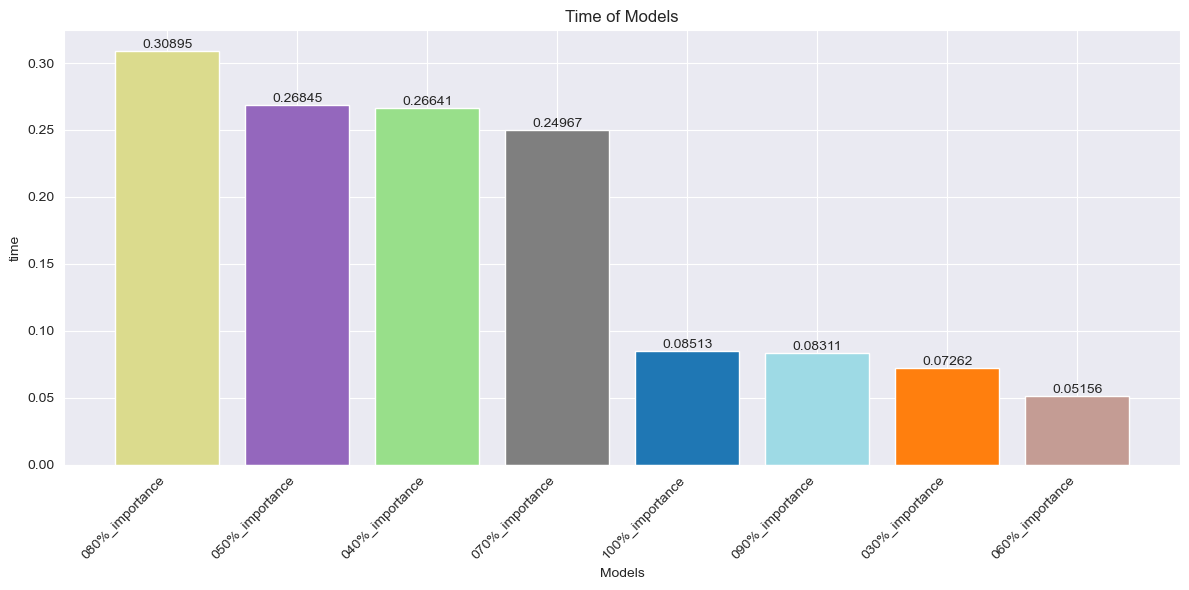

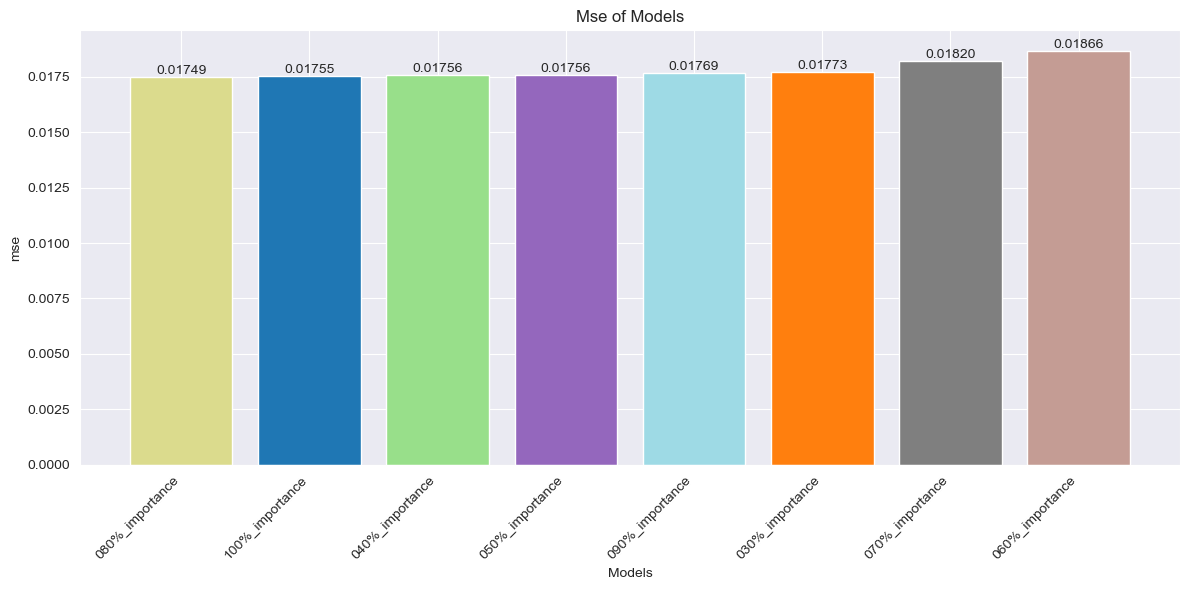

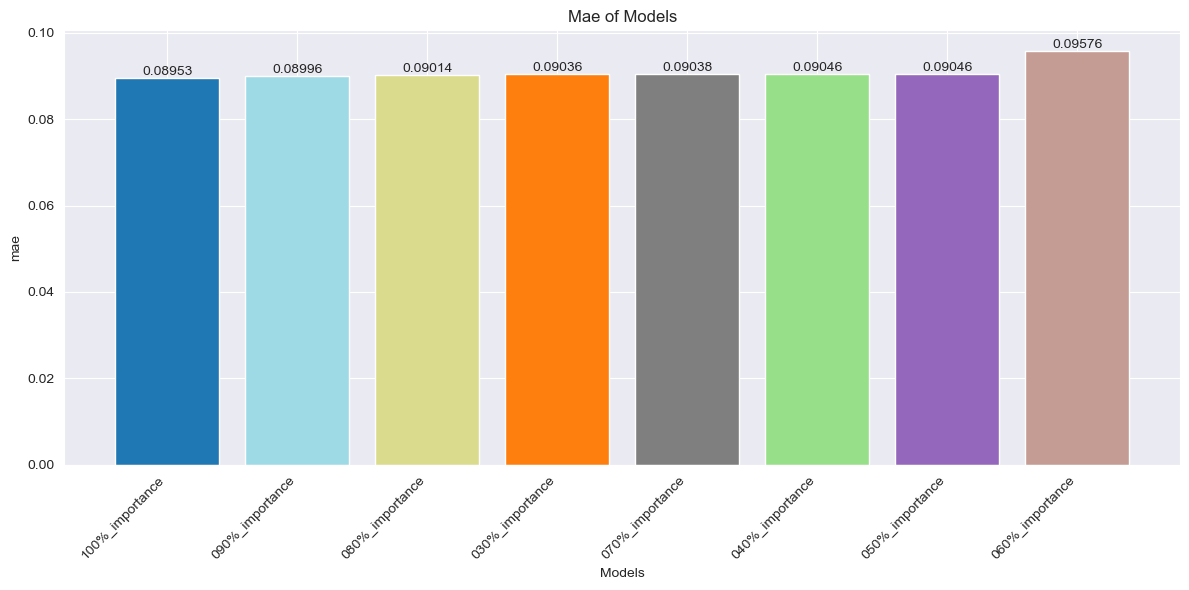

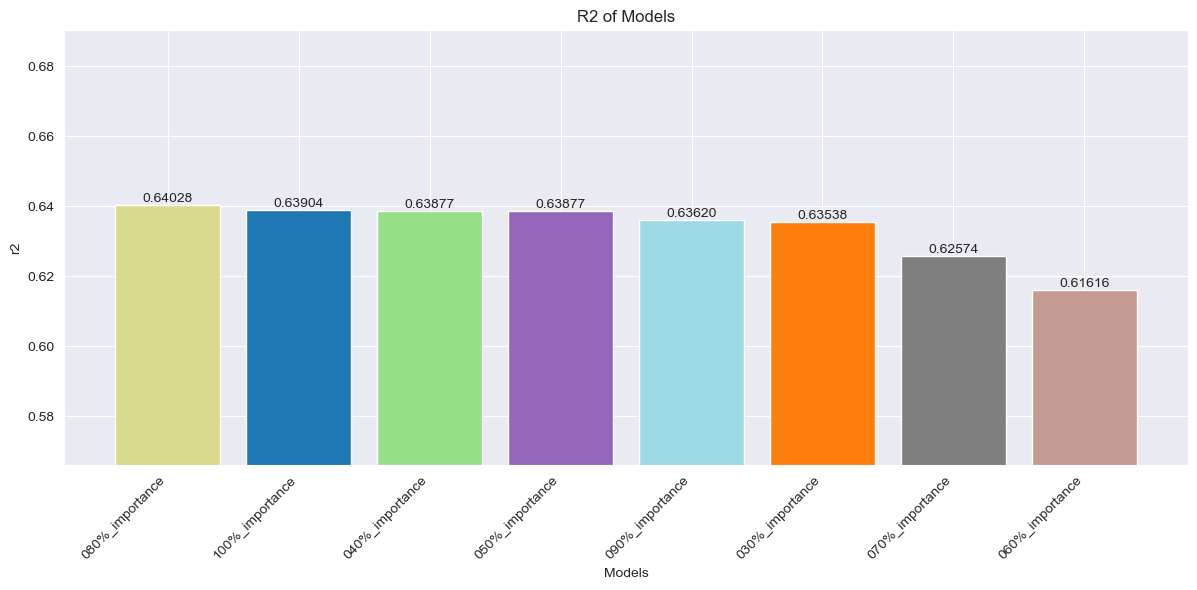

In [42]:
plot_results(df_results, metric_name="time", asc=False)
plot_results(df_results, metric_name="mse", asc=True)
plot_results(df_results, metric_name="mae", asc=True)
plot_results(df_results, metric_name="r2", asc=False, bottom=min(df_results["r2"])-0.05, top=max(df_results["r2"])+0.05)